In [1]:
# load and plot dataset
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot

Month
1901-01-01    266.0
1901-02-01    145.9
1901-03-01    183.1
1901-04-01    119.3
1901-05-01    180.3
Name: Sales, dtype: float64


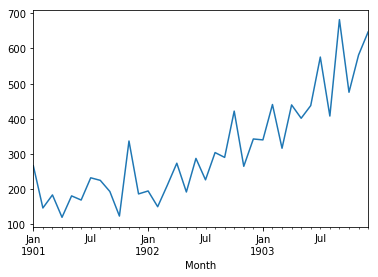

In [4]:
# load dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')
series = read_csv('sales-of-shampoo-over-a-three-ye.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
# summarize first few rows
print(series.head())
# line plot
series.plot()
pyplot.show()

In [2]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
import matplotlib
import numpy
from numpy import concatenate

# date-time parsing function for loading the dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	return df

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, yhat):
	new_row = [x for x in X] + [yhat]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states() # reset the states after each epoch
	return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]

# run a repeated experiment
def experiment(repeats, series):
	# transform data to be stationary
	raw_values = series.values
	diff_values = difference(raw_values, 1)
	# transform data to be supervised learning
	supervised = timeseries_to_supervised(diff_values, 1)
	supervised_values = supervised.values[1:,:]
	# split data into train and test-sets
	train, test = supervised_values[0:-12, :], supervised_values[-12:, :]
	# transform the scale of the data
	scaler, train_scaled, test_scaled = scale(train, test)
	# run experiment
	error_scores = list()
	for r in range(repeats):
		# fit the base model
		lstm_model = fit_lstm(train_scaled, 1, 1000, 1)
		# forecast test dataset
		predictions = list()
		for i in range(len(test_scaled)):
			# predict
			X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
			yhat = forecast_lstm(lstm_model, 1, X)
			# invert scaling
			yhat = invert_scale(scaler, X, yhat)
			# invert differencing
			yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
			# store forecast
			predictions.append(yhat)
		# report performance
		rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
		print('%d) Test RMSE: %.3f' % (r+1, rmse))
		error_scores.append(rmse)
	return error_scores

# execute the experiment
def run():
	# load dataset
	series = read_csv('sales-of-shampoo-over-a-three-ye.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
	# experiment
	repeats = 20
	results = DataFrame()
	# run experiment
	results['results'] = experiment(repeats, series)
	# summarize results
	print(results.describe())
	# save results
	results.to_csv('experiment_stateful.csv', index=False)

 # entry point
run()

1) Test RMSE: 117.219
2) Test RMSE: 99.069
3) Test RMSE: 96.101
4) Test RMSE: 104.065
5) Test RMSE: 93.061
6) Test RMSE: 99.081
7) Test RMSE: 98.159
8) Test RMSE: 138.595
9) Test RMSE: 93.817
10) Test RMSE: 107.475
11) Test RMSE: 97.216
12) Test RMSE: 141.080
13) Test RMSE: 100.145
14) Test RMSE: 96.667
15) Test RMSE: 101.737
16) Test RMSE: 100.734
17) Test RMSE: 99.316
18) Test RMSE: 97.844
19) Test RMSE: 96.690
20) Test RMSE: 98.421
          results
count   20.000000
mean   103.824574
std     13.379393
min     93.061487
25%     97.084555
50%     99.074954
75%    102.318963
max    141.079653


         stateful   stateful2
count   10.000000   10.000000
mean   102.196058  101.074157
std      4.270701    5.915999
min     95.302912   94.364410
25%    100.646964   96.487480
50%    101.716128   99.887535
75%    105.094503  103.848982
max    108.688054  110.805222


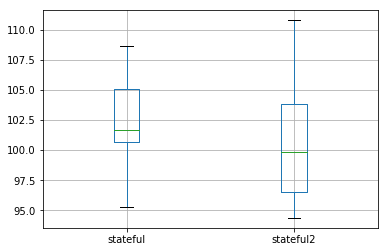

In [20]:
from pandas import DataFrame
from pandas import read_csv
from matplotlib import pyplot
# load results into a dataframe
filenames = ['experiment_stateful.csv', 'experiment_stateful2.csv']
results = DataFrame()
for name in filenames:
	results[name[11:-4]] = read_csv(name, header=0)
# describe all results
print(results.describe())
# box and whisker plot
results.boxplot()
pyplot.show()

In [1]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
import matplotlib
import numpy
from numpy import concatenate

# date-time parsing function for loading the dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	return df

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, yhat):
	new_row = [x for x in X] + [yhat]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=False))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=True)
		model.reset_states() # reset the states after each epoch
	return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]

# run a repeated experiment
def experiment(repeats, series):
	# transform data to be stationary
	raw_values = series.values
	diff_values = difference(raw_values, 1)
	# transform data to be supervised learning
	supervised = timeseries_to_supervised(diff_values, 1)
	supervised_values = supervised.values[1:,:]
	# split data into train and test-sets
	train, test = supervised_values[0:-12, :], supervised_values[-12:, :]
	# transform the scale of the data
	scaler, train_scaled, test_scaled = scale(train, test)
	# run experiment
	error_scores = list()
	for r in range(repeats):
		# fit the base model
		lstm_model = fit_lstm(train_scaled, 1, 1000, 1)
		# forecast test dataset
		predictions = list()
		for i in range(len(test_scaled)):
			# predict
			X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
			yhat = forecast_lstm(lstm_model, 1, X)
			# invert scaling
			yhat = invert_scale(scaler, X, yhat)
			# invert differencing
			yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
			# store forecast
			predictions.append(yhat)
		# report performance
		rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
		print('%d) Test RMSE: %.3f' % (r+1, rmse))
		error_scores.append(rmse)
	return error_scores

# execute the experiment
def run():
	# load dataset
	series = read_csv('sales-of-shampoo-over-a-three-ye.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
	# experiment
	repeats = 20
	results = DataFrame()
	# run experiment
	results['results'] = experiment(repeats, series)
	# summarize results
	print(results.describe())
	# save results
	results.to_csv('experiment_stateless.csv', index=False)

 # entry point
run()

Using TensorFlow backend.


1) Test RMSE: 94.471
2) Test RMSE: 98.235
3) Test RMSE: 101.418
4) Test RMSE: 96.421
5) Test RMSE: 94.290
6) Test RMSE: 93.682
7) Test RMSE: 94.519
8) Test RMSE: 95.688
9) Test RMSE: 97.289
10) Test RMSE: 93.926
11) Test RMSE: 93.967
12) Test RMSE: 93.260
13) Test RMSE: 94.341
14) Test RMSE: 96.699
15) Test RMSE: 93.787
16) Test RMSE: 96.589
17) Test RMSE: 98.345
18) Test RMSE: 93.501
19) Test RMSE: 96.706
20) Test RMSE: 94.778
          results
count   20.000000
mean    95.595658
std      2.102662
min     93.260407
25%     93.956748
50%     94.648329
75%     96.700584
max    101.417782


In [4]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
import matplotlib
import numpy
from numpy import concatenate

# date-time parsing function for loading the dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	return df

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, yhat):
	new_row = [x for x in X] + [yhat]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=False))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states() # reset the states after each epoch
	return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]

# run a repeated experiment
def experiment(repeats, series):
	# transform data to be stationary
	raw_values = series.values
	diff_values = difference(raw_values, 1)
	# transform data to be supervised learning
	supervised = timeseries_to_supervised(diff_values, 1)
	supervised_values = supervised.values[1:,:]
	# split data into train and test-sets
	train, test = supervised_values[0:-12, :], supervised_values[-12:, :]
	# transform the scale of the data
	scaler, train_scaled, test_scaled = scale(train, test)
	# run experiment
	error_scores = list()
	for r in range(repeats):
		# fit the base model
		lstm_model = fit_lstm(train_scaled, 1, 1000, 1)
		# forecast test dataset
		predictions = list()
		for i in range(len(test_scaled)):
			# predict
			X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
			yhat = forecast_lstm(lstm_model, 1, X)
			# invert scaling
			yhat = invert_scale(scaler, X, yhat)
			# invert differencing
			yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
			# store forecast
			predictions.append(yhat)
		# report performance
		rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
		print('%d) Test RMSE: %.3f' % (r+1, rmse))
		error_scores.append(rmse)
	return error_scores

# execute the experiment
def run():
	# load dataset
	series = read_csv('sales-of-shampoo-over-a-three-ye.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
	# experiment
	repeats = 20
	results = DataFrame()
	# run experiment
	results['results'] = experiment(repeats, series)
	# summarize results
	print(results.describe())
	# save results
	results.to_csv('experiment_stateless_no_shuffle.csv', index=False)

 # entry point
run()

1) Test RMSE: 96.501
2) Test RMSE: 93.136
3) Test RMSE: 94.636
4) Test RMSE: 95.020
5) Test RMSE: 95.254
6) Test RMSE: 94.454
7) Test RMSE: 94.864
8) Test RMSE: 97.269
9) Test RMSE: 97.213
10) Test RMSE: 96.088
11) Test RMSE: 93.685
12) Test RMSE: 95.581
13) Test RMSE: 97.726
14) Test RMSE: 95.656
15) Test RMSE: 94.192
16) Test RMSE: 93.699
17) Test RMSE: 98.066
18) Test RMSE: 96.837
19) Test RMSE: 95.787
20) Test RMSE: 94.277
         results
count  20.000000
mean   95.497084
std     1.427695
min    93.135578
25%    94.409417
50%    95.417678
75%    96.585327
max    98.066335


         stateful   stateless  stateless_no_shuffle
count   20.000000   20.000000             20.000000
mean   103.824574   95.595658             95.497084
std     13.379393    2.102662              1.427695
min     93.061487   93.260407             93.135578
25%     97.084555   93.956748             94.409417
50%     99.074954   94.648329             95.417678
75%    102.318963   96.700584             96.585327
max    141.079653  101.417782             98.066335


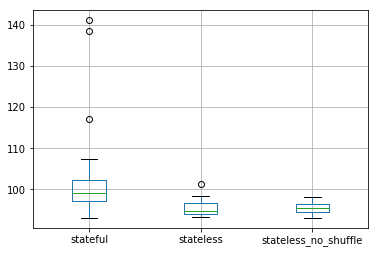

In [3]:
from pandas import DataFrame
from pandas import read_csv
from matplotlib import pyplot
# load results into a dataframe
filenames = ['experiment_stateful.csv', 'experiment_stateless.csv',
	'experiment_stateless_no_shuffle.csv']
results = DataFrame()
for name in filenames:
	results[name[11:-4]] = read_csv(name, header=0)
# describe all results
print(results.describe())
# box and whisker plot
results.boxplot()
pyplot.show()

In [14]:
train, test = supervised_values[0:-12, :], supervised_values[-12:, :]

In [15]:
scaler, train_scaled, test_scaled = scale(train, test)
scaler

MinMaxScaler(copy=True, feature_range=(-1, 1))

In [16]:
X, y = train_scaled[:, 0:-1], train_scaled[:, -1]


In [18]:
X.shape

(22, 1)